In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ccxt
import time

import ta  # Technical Analysis Library (pip install ta)


In [5]:
exchange = ccxt.binance() # binance api

# OHLCV = Open, High, Low, Close, Volume
symbol = "BTC/USDT"
timeframe = "1h"  # 1h = stündliche Daten
limit = 1000      # max. pro Request
since = exchange.parse8601("2021-01-01T00:00:00Z")

all_candles = []
while since < exchange.milliseconds():
    candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    if not candles:
        break
    all_candles += candles
    since = candles[-1][0] + 1
    time.sleep(exchange.rateLimit / 1000)  # Binance nicht überlasten

# In DataFrame packen
df = pd.DataFrame(all_candles, columns=["timestamp", "open", "high", "low", "close", "volume"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

df.head()


,timestamp,open,high,low,close,volume
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803


In [10]:
df.to_csv("/home/nina/crypto-ml-trading/data/btcusdt_1h.csv", index=False)
print("gespeichert unter /home/nina/crypto-ml-trading/data/btcusdt_1h.csv")


gespeichert unter /home/nina/crypto-ml-trading/data/btcusdt_1h.csv


In [14]:
df = pd.read_csv("/home/nina/crypto-ml-trading/data/btcusdt_1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,open,high,low,close,volume
timestamp,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803


In [15]:
# Returns
df["return_1h"] = df["close"].pct_change()
df["return_24h"] = df["close"].pct_change(24)

# Rolling Volatility
df["volatility_24h"] = df["return_1h"].rolling(window=24).std()

# Simple Moving Averages
df["sma_10"] = df["close"].rolling(window=10).mean()
df["sma_50"] = df["close"].rolling(window=50).mean()
df["sma_200"] = df["close"].rolling(window=200).mean()

# RSI (Relative Strength Index)
import ta
df["rsi_14"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()

# MACD
macd = ta.trend.MACD(df["close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()
df["macd_diff"] = macd.macd_diff()


In [16]:
df[["close", "return_1h", "volatility_24h", "sma_50", "rsi_14"]].tail(10)


,close,return_1h,volatility_24h,sma_50,rsi_14
timestamp,,,,,
2025-09-29 13:00:00,113227.29,0.010758,0.003164,110409.3562,82.419436
2025-09-29 14:00:00,114033.53,0.007121,0.003375,110502.0258,86.354548
2025-09-29 15:00:00,113815.57,-0.001911,0.003449,110592.2050,81.071442
2025-09-29 16:00:00,113626.15,-0.001664,0.003505,110678.9702,76.680834
2025-09-29 17:00:00,114043.91,0.003677,0.003524,110771.8036,79.338521
2025-09-29 18:00:00,114008.79,-0.000308,0.003540,110864.1986,78.528252
2025-09-29 19:00:00,114265.55,0.002252,0.003537,110961.8602,80.126271
2025-09-29 20:00:00,114258.29,-0.000064,0.003500,111058.3268,79.945095
2025-09-29 21:00:00,114176.73,-0.000714,0.003518,111153.3774,77.816361


In [18]:
df.to_csv("/home/nina/crypto-ml-trading/data/btcusdt_features.csv") # save for ML


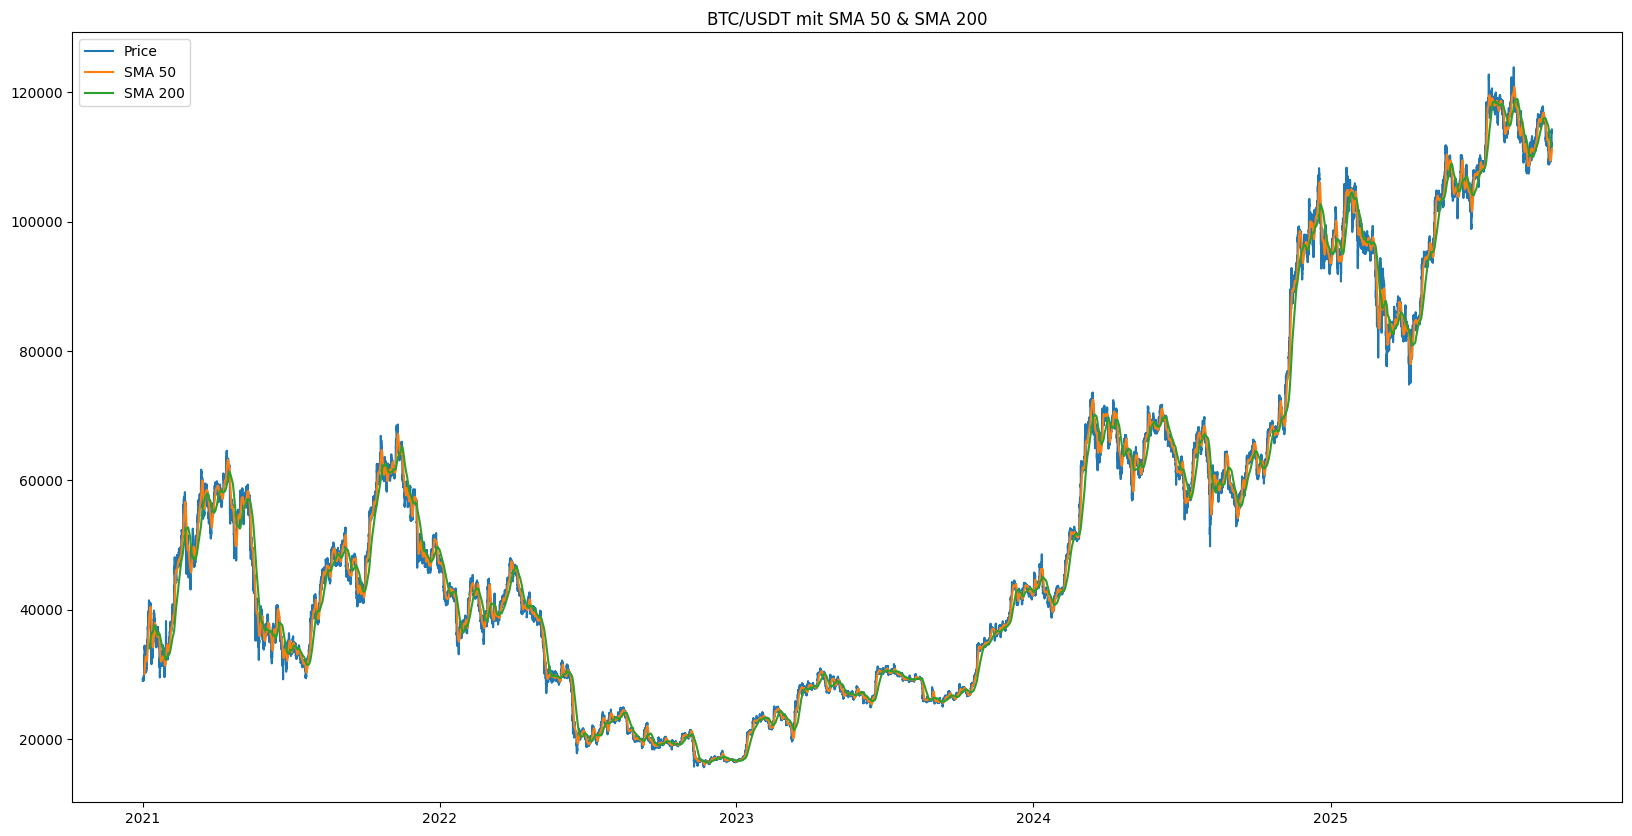

In [20]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df["close"], label="Price")
plt.plot(df.index, df["sma_50"], label="SMA 50")
plt.plot(df.index, df["sma_200"], label="SMA 200")
plt.legend()
plt.title("BTC/USDT mit SMA 50 & SMA 200")
plt.show()
